# TabNet

In [1]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

import pandas as pd
import numpy as np
np.random.seed(0)

import os
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Load data

In [2]:
PATH = Path('../data/houseprice/')

In [3]:
train = pd.read_csv(PATH/'train.csv', sep=',', header=0)
train.drop(['Id'], axis=1, inplace=True)
test = pd.read_csv(PATH/'test.csv', sep=',', header=0)
test.drop(['Id'], axis=1, inplace=True)

target = 'SalePrice'

if "Set" not in train.columns:
    train["Set"] = np.random.choice(['train', 'valid'], p=[.85, .15], size=(train.shape[0], ))
train_indices = train[train.Set=='train'].index
valid_indices = train[train.Set=='valid'].index

# Preprocess

In [4]:
n_train = len(train)

In [5]:
traintest = pd.concat([train, test], axis=0)

In [6]:
types = traintest.dtypes
nunique = traintest.nunique()
categorical_columns = []
categorical_dims = {}

In [7]:
unused_col = 'Set'
target_col = 'SalePrice'
features = [col for col in traintest.columns if col not in [target_col] + [unused_col]]

In [8]:
for col in features:
    if traintest[col].dtype=='object' or traintest[col].nunique() < 200:
        traintest[col].fillna('VV_likely', inplace=True)
        l_enc = LabelEncoder()
        l_enc.fit(traintest[col].astype(str))
        traintest[col] = l_enc.transform(traintest[col].astype(str))        
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    if traintest[col].nunique() >= 200:        
        traintest.fillna(traintest[col].mean(), inplace=True)        

In [9]:
train = traintest.iloc[:n_train]
test = traintest.iloc[n_train:]

In [10]:
len(train), len(test)

(1460, 1459)

In [11]:
unused_feat = ['Set']

# Categorical features for embeddings

In [12]:
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [13]:
cat_emb_dim = [min(50, (num_labels+1)//2) for num_labels in cat_dims]

In [14]:
num_idxs = [i for i, f in enumerate(features) if f not in categorical_columns]
num_idxs

[3, 25, 33, 35, 36, 37, 42, 43, 45, 61, 65, 66]

# Network parameters

In [15]:
tnr = TabNetRegressor(cat_idxs=cat_idxs, cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, optimizer_params=dict(lr=20.))

Device used : cpu


# Training

In [16]:
x_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

x_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

x_test = test[features].values

Convert numerical features to log distribution

In [17]:
# Convert numerical features to log+1 distribution
x_train[:,num_idxs] = np.log1p(x_train[:, num_idxs])
x_valid[:,num_idxs] = np.log1p(x_valid[:, num_idxs])
x_test[:,num_idxs] = np.log1p(x_test[:, num_idxs])

In [18]:
# Convert y to log distribution
y_train = np.log(y_train)
y_valid = np.log(y_valid)

In [19]:
train.columns[num_idxs]

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF'],
      dtype='object')

In [ ]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        self.eps = 1e-6
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = torch.nn.MSELoss()
        loss = torch.sqrt(criterion(x, y) + self.eps)
        return loss

In [ ]:
def rmsle(pred, y):
    """
    Compute the Root Mean Squared Log Error for hypthesis pred and targets y
    Args:
        pred - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return torch.sqrt(((torch.log(pred + 1) - torch.log(y + 1))**2).mean())

In [ ]:
def rmsle2(pred, y):
    """
    Compute the Root Mean Squared Log Error for hypthesis pred and targets y
    Args:
        pred - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    # return torch.sqrt(((pred - torch.log(y + 1))**2).mean())
    return torch.sqrt(sum((pred - torch.log(y + 1))**2) / len(pred))

In [ ]:
def rmsle3(pred, y):
    """
    Compute the Root Mean Squared Log Error for hypthesis pred and targets y
    Args:
        pred - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return torch.sqrt(((pred - y)**2).mean())

In [29]:
tnr = TabNetRegressor(n_d=16, n_a=64,
                      gamma = 1.2,
                      cat_idxs=cat_idxs, cat_dims=cat_dims, cat_emb_dim=cat_emb_dim,
                      lambda_sparse=1e-3,
                      optimizer_params=dict(lr=2e-2),
                      n_steps=5,
                      momentum=0.8)

Device used : cpu


In [22]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

## debug

In [ ]:
weights = 0
batch_size = 1024
virtual_batch_size = 128
num_workers = 0
drop_last = False
loss_fn = rmsle2
# loss_fn = rmsle
# loss_fn = torch.nn.functional.mse_loss

patience = 5

In [ ]:
tnr.update_fit_params(x_train, y_train, x_valid, y_valid,
                      loss_fn,
                      weights,
                      max_epochs, patience,
                      batch_size, virtual_batch_size,
                      num_workers,
                      drop_last)

In [ ]:
train_dataloader, valid_dataloader = tnr.construct_loaders(x_train, y_train,
                                                           x_valid, y_valid,
                                                           weights,
                                                           batch_size,
                                                           num_workers,
                                                           drop_last)

In [ ]:
tnr.init_network(tnr.input_dim, tnr.output_dim,
                 tnr.n_d, tnr.n_a,
                 tnr.n_steps,
                 tnr.gamma,
                 cat_idxs, cat_dims, cat_emb_dim=cat_emb_dim,
                 n_independent=tnr.n_independent,
                 n_shared=tnr.n_shared,
                 epsilon=tnr.epsilon,
                 virtual_batch_size=virtual_batch_size,
                 momentum=tnr.momentum,
                 device_name=tnr.device_name,
                 mask_type=tnr.mask_type)

In [ ]:
tnr.optimizer = tnr.optimizer_fn(tnr.network.parameters(), **tnr.optimizer_params)

# tnr.optimizer

In [ ]:
tnr.losses_train = []
tnr.losses_valid = []
tnr.learning_rates = []
tnr.metrics_train = []
tnr.metrics_valid = []

In [ ]:
tnr.learning_rates.append(tnr.optimizer.param_groups[-1]["lr"])

In [ ]:
tnr.scheduler = None

### fit_epoch()

In [ ]:
# not working
# train_metrics = tnr.train_epoch(train_dataloader)

#### train_epoch(train_loader)

In [ ]:
tnr.network.train()

y_preds = []
ys = []
total_loss = 0

In [ ]:
train_loader = train_dataloader

In [ ]:
data, targets = next(iter(train_loader))

In [ ]:
# not working
# batch_outs = tnr.train_batch(data, targets)

##### train_batch(data, targets)

In [ ]:
device_name = 'auto'
if device_name == 'auto':
    if torch.cuda.is_available():
        device_name = 'cuda'
    else:
        device_name = 'cpu'
tnr.device = torch.device(device_name)

In [ ]:
tnr.network.train()
data = data.to(device_name).float()

In [ ]:
targets = targets.to(tnr.device).float()

In [ ]:
tnr.optimizer.zero_grad()

In [ ]:
output, M_loss = tnr.network(data)

In [ ]:
loss = tnr.loss_fn(output, targets)

In [ ]:
loss

In [ ]:
torch.sum((output + 1.) < 0).true_divide(len(output))

In [ ]:
(torch.log(output + 1) - torch.log(targets + 1))**2

In [ ]:
torch.sort(torch.log(output+1), dim=0)

In [ ]:
torch.sort(output+1, dim=0)

In [ ]:
torch.sort(output, dim=0)

In [ ]:
torch.log(torch.Tensor([3.6085]))

In [ ]:
res = ((torch.log(output + 1) - torch.log(targets + 1))**2).detach()
res

In [ ]:
torch.sort(res, dim=0)

#### predict_epoch(valid_loader)

In [ ]:
valid_metrics = tnr.predict_epoch(valid_dataloader)

In [ ]:
train_loader = train_dataloader
valid_loader = valid_dataloader

data, targets = next(iter(train_loader))

In [ ]:
tnr.network.train()

In [ ]:
tnr.network.embedder(data.to(tnr.device))

In [ ]:
data = data.to(tnr.device).float()
targets = targets.to(tnr.device).float()
tnr.optimizer.zero_grad()

In [ ]:
data.shape

In [ ]:
tnr.input_dim

In [ ]:
output, M_Loss = tnr.network(data)

In [ ]:
tnr.train_batch(data, targets)

In [ ]:
prior = torch.ones(x_test.shape)

### forward breakdown

#### get some data

In [ ]:
from torch.nn import BatchNorm1d

In [ ]:
from pytorch_tabnet.tab_network import FeatTransformer, AttentiveTransformer

In [ ]:
xb, yb = next(iter(train_dataloader))

In [ ]:
pd.DataFrame(xb)

In [ ]:
xb.shape

In [ ]:
sum(cat_emb_dim) + 79 - len(cat_idxs)

#### init

In [ ]:
# input_dim = xb.shape[1]
input_dim = sum(cat_emb_dim) + 79 - len(cat_idxs)
output_dim = 1  # For regression
n_shared = 2
n_steps = 2
n_a = 8  # dimension of attention layer
n_d = 4  # dimension of decision layer
n_independent = 2  # number of independent GLU layers in each GLU block (default = 2)

epsilon = 1e-15  # avoid log(0)
gamma = 1.3  # Float above 1, scaling factor for attention updates (1.0 .. 2.0)

momentum = 0.01  # momentum used for all BN layers (also GBN) except for initial_bn

mask_type = "sparsemax"  # or "entmax"

batch_size = 1024
virtual_batch_size = 128

##### Initial Batchnorm

In [ ]:
# input_dim_emb includes embeddings
initial_bn = BatchNorm1d(input_dim, momentum=0.01)
initial_bn

In [ ]:
n_shared

##### Initial splitter

In [ ]:
if n_shared > 0:
    shared_feat_transform = torch.nn.ModuleList()
    
    for i in range(n_shared):
        if i == 0:
            shared_feat_transform.append(
                torch.nn.Linear(input_dim, 2*(n_a + n_d), bias=False)
            )
        else:
            shared_feat_transform.append(
                torch.nn.Linear(n_a + n_d, 2*(n_a + n_d), bias=False)
            )
else:
    shared_feat_transform = None
shared_feat_transform

In [ ]:
initial_splitter = FeatTransformer(input_dim=input_dim,
                                   output_dim=n_a + n_d,
                                   shared_layers=shared_feat_transform,
                                   n_glu_independent=n_independent,  # number of modules in specifics
                                   virtual_batch_size=virtual_batch_size,
                                   momentum=momentum)
initial_splitter

##### Attentive Transformers and Feature Transformers

In [ ]:
feat_transformers = torch.nn.ModuleList()
att_transformers = torch.nn.ModuleList()

In [ ]:
for step in range(n_steps):
    transformer = FeatTransformer(input_dim=input_dim,
                                  output_dim = n_a+n_d,
                                  shared_layers=shared_feat_transform,
                                  n_glu_independent=n_independent,
                                  virtual_batch_size=virtual_batch_size,
                                  momentum=momentum
                                 )
    attention = AttentiveTransformer(input_dim=n_a,
                                     output_dim=input_dim,
                                     virtual_batch_size=virtual_batch_size,
                                     momentum=momentum,
                                     mask_type=mask_type
                                    )
    feat_transformers.append(transformer)
    att_transformers.append(attention)

In [ ]:
feat_transformers

In [ ]:
att_transformers

##### Final mapping

In [ ]:
def initialize_non_glu(module, input_dim, output_dim):
    gain_value = np.sqrt((input_dim+output_dim)/np.sqrt(4*input_dim))
    torch.nn.init.xavier_normal_(module.weight, gain=gain_value)
    # torch.nn.init.zeros_(module.bias)
    return

In [ ]:
final_mapping = torch.nn.Linear(n_d, output_dim, bias=False)

In [ ]:
initialize_non_glu(final_mapping, n_d, output_dim)

In [ ]:
final_mapping

#### forward

##### TabNet

In [ ]:
from pytorch_tabnet.tab_network import EmbeddingGenerator

In [ ]:
input_dim_noemb = 79 # for the embedder
embedder = EmbeddingGenerator(input_dim_noemb, cat_dims, cat_idxs, cat_emb_dim)

In [ ]:
xb.shape

In [ ]:
x = embedder(xb)

In [ ]:
x.shape

In [ ]:
# This is the first numerical column in the new dataset after the embeddings transformation
# pd.DataFrame(x[:,61])

##### TabNetNoEmbeddings

In [ ]:
res = 0

In [ ]:
x.mean(), x.std()

In [ ]:
x.shape

In [ ]:
# new input dim including embeddings
input_dim = sum(cat_emb_dim) + 79 - len(cat_idxs)

In [ ]:
x_bn = initial_bn(x)

In [ ]:
x_bn.mean(), x_bn.std()

In [ ]:
prior = torch.ones(x_bn.shape)
M_loss = 0

In [ ]:
att_full = initial_splitter(x_bn)

In [ ]:
att_full

In [ ]:
att_full.shape

In [ ]:
n_d, n_a

In [ ]:
att = initial_splitter(x_bn)[:, n_d:]

In [ ]:
att.shape

In [ ]:
n_steps = 2

**for step in range(n_steps)**

In [ ]:
M = att_transformers[1](prior, att)
M_loss += torch.mean(torch.sum(torch.mul(M, torch.log(M+epsilon)), dim=1))
M_loss

In [ ]:
M_det = M.detach()
plt.matshow(M_det)

In [ ]:
prior = torch.mul(gamma - M, prior)
prior

In [ ]:
masked_x = torch.mul(M, x_bn)
masked_x

**feat transformer**

In [ ]:
out = feat_transformers[0](masked_x)
out

In [ ]:
from torch.nn.modules import ReLU

In [ ]:
d = ReLU()(out[:, :n_d])
d, d.shape

In [ ]:
res = torch.add(res, d)
res

In [ ]:
att = out[:, n_d:]
att

In [ ]:
att.shape

**end for**

In [ ]:
M_loss /= n_steps
res = final_mapping(res)

In [ ]:
M_loss, res, res.shape

## grid search

In [116]:
steps = 4
hyper = {}
hyper['n_d'] = [8, 16, 24, 32, 64, 128]
hyper['n_a'] = [8, 16, 24, 32, 64, 128]
hyper['steps'] = range(3,11)
# hyper[n_a] = [8, 128]
# hyper[n_steps] = [3, 10]
# hyper[gamma] = [1., 2.]
# hyper[lamb_sparse] = [0., 0.00001, 0.0001, 0.001, 0.01, 0.1]
# hyper[m_b] = [0.6, 0.7, 0.8, 0.9, 0.95, 0.98]

In [119]:
def grid_search(hyper):
    train_losses = {}
    train_losses['n_a'] = {}
    valid_losses = {}
    valid_losses['n_a'] = {}
    train_losses = {}
    train_losses['n_d'] = {}
    valid_losses = {}
    valid_losses['n_d'] = {}
    train_losses = {}
    train_losses['steps'] = {}
    valid_losses = {}
    valid_losses['steps'] = {}
    
    for val in hyper['steps']:
        tnr = TabNetRegressor(n_d=16, n_a=64, gamma = 1.2, cat_idxs=cat_idxs,
                              cat_dims=cat_dims, cat_emb_dim=cat_emb_dim,
                              lambda_sparse=1e-3,
                              verbose=0,
                              optimizer_params=dict(lr=2e-2),
                              n_steps=val, momentum=0.8)
        tnr.fit(X_train=x_train, y_train=y_train, X_valid=x_valid, y_valid=y_valid,
                loss_fn=mse_loss, weights=0, max_epochs=max_epochs, patience=10,
                batch_size=1024, virtual_batch_size=128, num_workers=0,
                drop_last=False)
        train_losses['steps'][val] = tnr.losses_train
        valid_losses['steps'][val] = tnr.losses_valid
    return (train_losses, valid_losses)

In [ ]:
train_losses, valid_losses = grid_search(hyper)

Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu


In [41]:
train_losses

{'n_d': {8: [160.4892120361328,
   143.49645233154297,
   128.22565841674805,
   116.60872268676758,
   105.40204238891602,
   93.57222747802734,
   80.54077911376953,
   69.55436325073242,
   58.53718566894531,
   46.80454444885254,
   34.91719150543213,
   27.822813034057617,
   18.765625953674316,
   13.166674137115479,
   9.468586921691895,
   7.910143136978149,
   7.930732011795044,
   5.45898175239563,
   4.052290678024292,
   3.4026622772216797],
  16: [137.1658706665039,
   98.58234405517578,
   72.99506759643555,
   48.11761283874512,
   33.633578300476074,
   19.52983283996582,
   15.844078540802002,
   18.375876426696777,
   15.195430278778076,
   11.440150737762451],
  24: [124.42230606079102,
   78.10523986816406,
   45.11708641052246,
   30.105953216552734,
   22.024771690368652,
   18.630414962768555],
  32: [191.93223571777344,
   130.62258911132812,
   81.63953399658203,
   50.92464256286621,
   30.18311882019043,
   20.175514221191406],
  64: [102.025390625, 37.328644

In [ ]:
grid_search(hyper, steps)

In [ ]:
from torch.nn.functional import mse_loss

In [ ]:
def plot_losses(obj):
    fig, ax = plt.subplots(figsize=[14, 7], dpi=100)
    ax.set_title('Training/validation loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.set_ylim(0., 1.)
    ax.grid(True, color='#dddddd')
    ax.plot(obj.losses_train, label='train loss', linewidth=0.5)
    ax.plot(obj.losses_valid, label='valid loss', linewidth=0.5)
    ax.legend()
    plt.plot()    

In [112]:
def plot_all_losses(valid_losses):
    fig, ax = plt.subplots(figsize=[14, 7], dpi=100)
    ax.set_title('Training/validation loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.set_ylim(0., 6.)
    ax.grid(True, color='#dddddd')
    # ax.plot(obj.losses_train, label='train loss', linewidth=0.5)
    for val in valid_losses['n_a']:
        ax.plot(valid_losses['n_a'][val], label=f'valid loss n_a={val}', linewidth=0.5)
    ax.legend()
    plt.plot()    

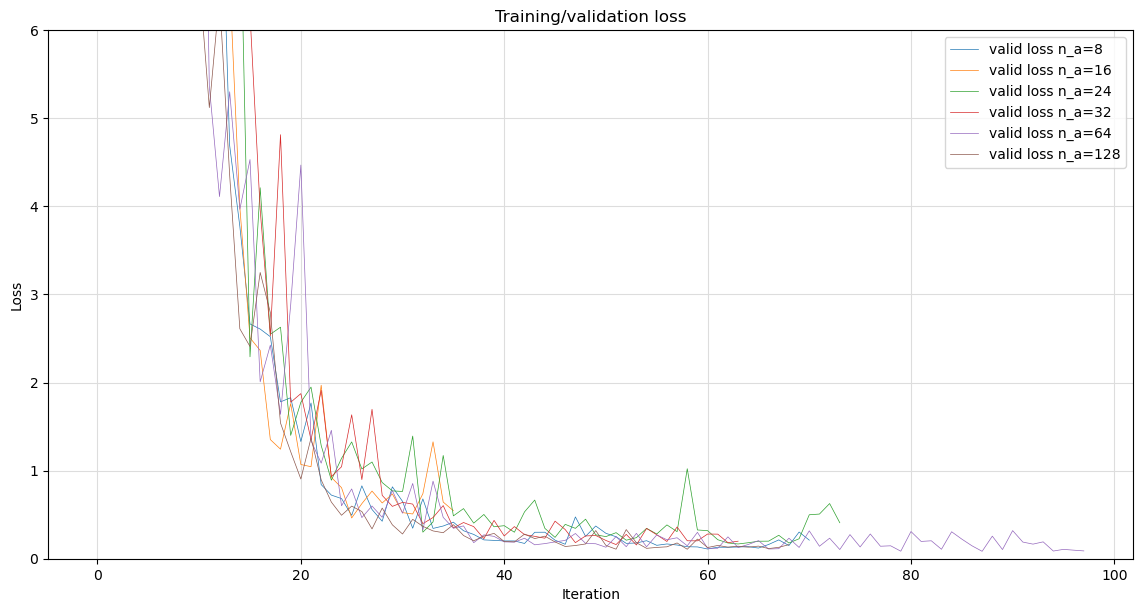

In [113]:
plot_all_losses(valid_losses)

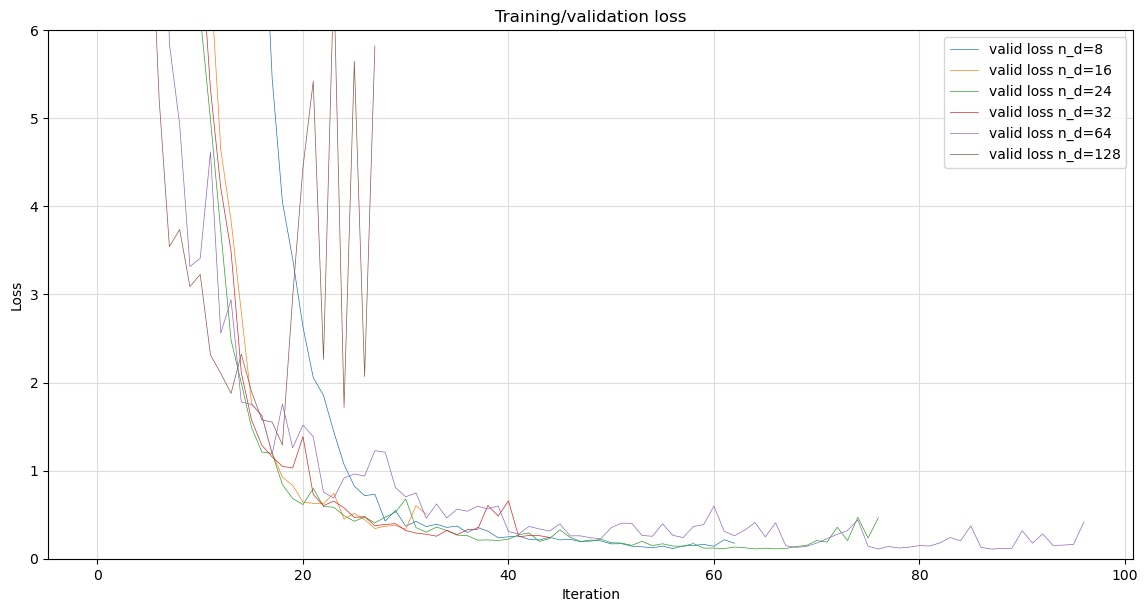

In [67]:
plot_all_losses(train_losses)

In [114]:
for val in valid_losses['n_a']:
    print(f"{val}\t{min(valid_losses['n_a'][val])}")

8	0.11027364432811737
16	0.4626123309135437
24	0.16744685173034668
32	0.15631073713302612
64	0.08409054577350616
128	0.10753074288368225


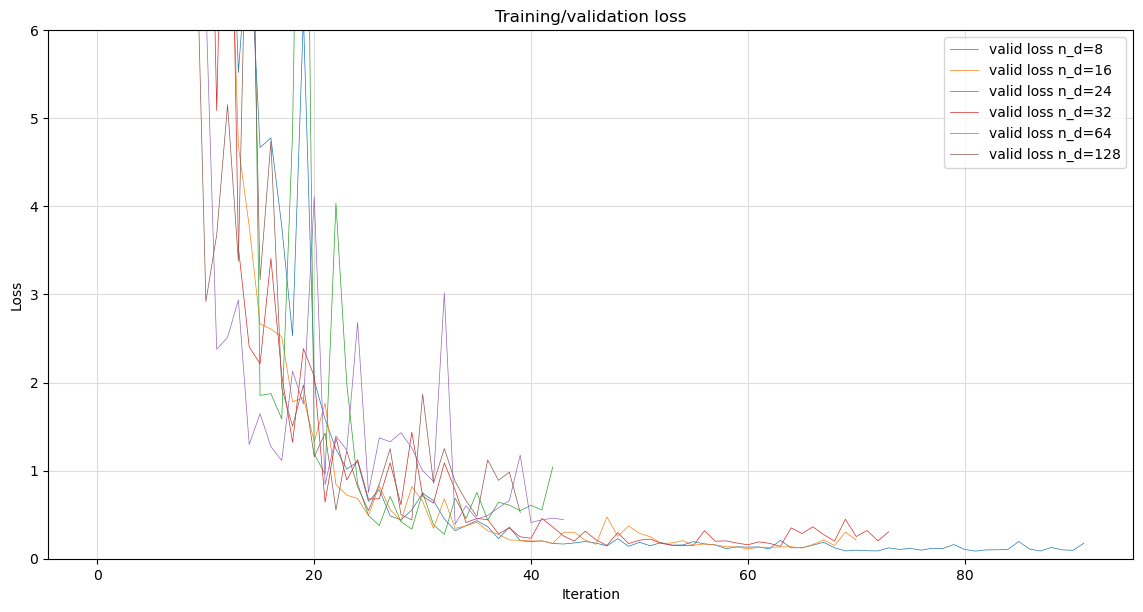

In [81]:
plot_all_losses(valid_losses)

In [82]:
for val in valid_losses['n_d']:
    print(f"{val}\t{min(valid_losses['n_d'][val])}")

8	0.08668289333581924
16	0.11027364432811737
24	0.2751639485359192
32	0.14097559452056885
64	0.3904086947441101
128	0.44060125946998596


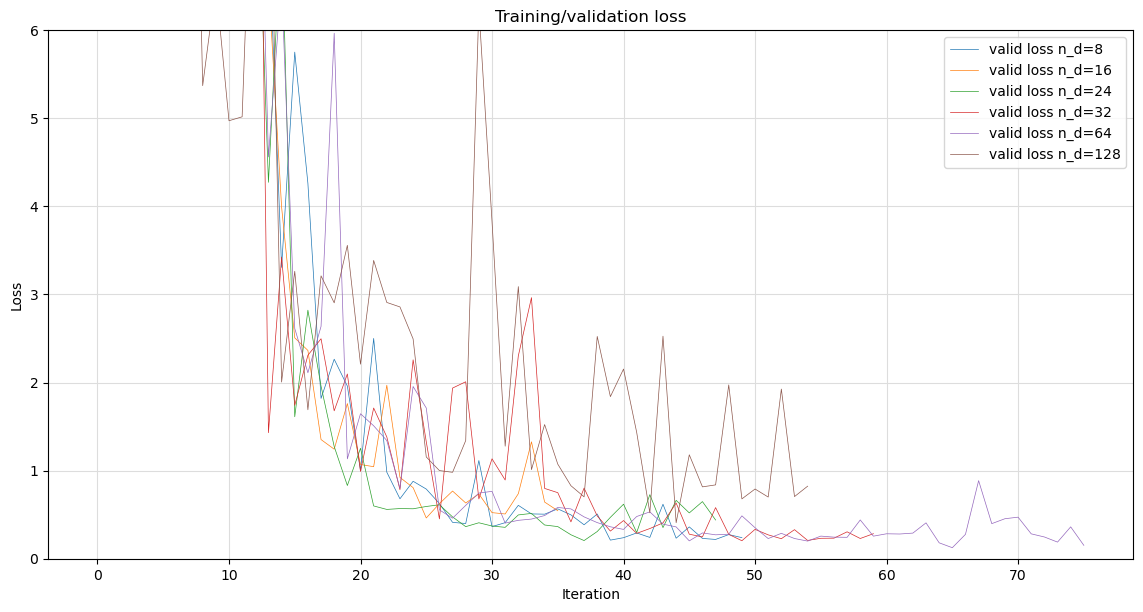

In [85]:
plot_all_losses(valid_losses)

In [86]:
for val in valid_losses['n_d']:
    print(f"{val}\t{min(valid_losses['n_d'][val])}")

8	0.211209237575531
16	0.4626123309135437
24	0.20604947209358215
32	0.20415028929710388
64	0.12521640956401825
128	0.40841707587242126


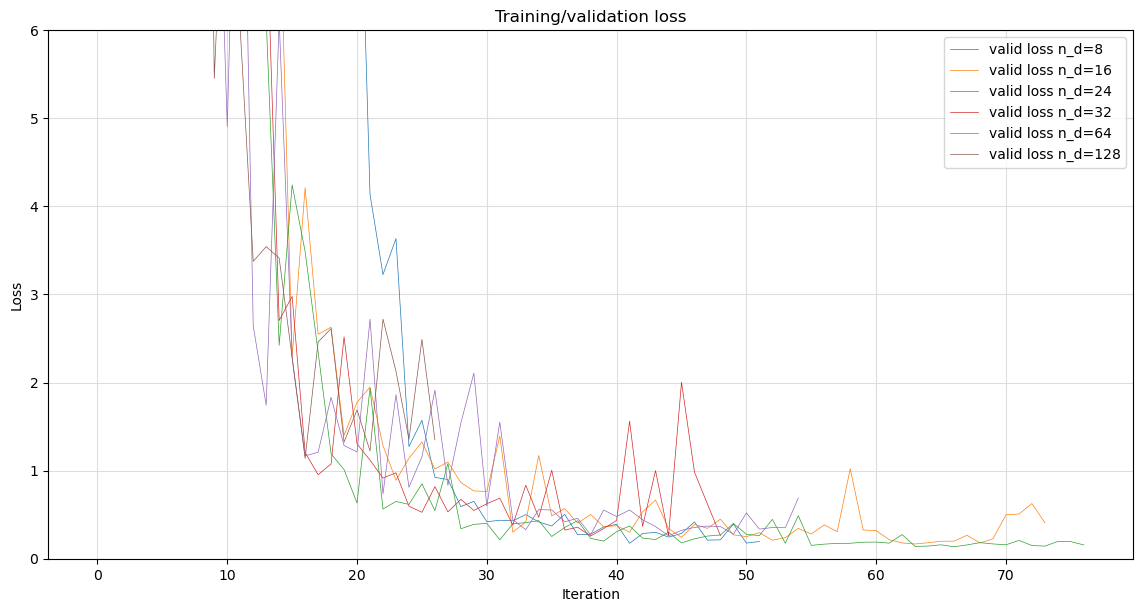

In [89]:
plot_all_losses(valid_losses)

In [90]:
for val in valid_losses['n_d']:
    print(f"{val}\t{min(valid_losses['n_d'][val])}")

8	0.17497843503952026
16	0.16744685173034668
24	0.13597509264945984
32	0.2579304277896881
64	0.25982218980789185
128	1.1384446620941162


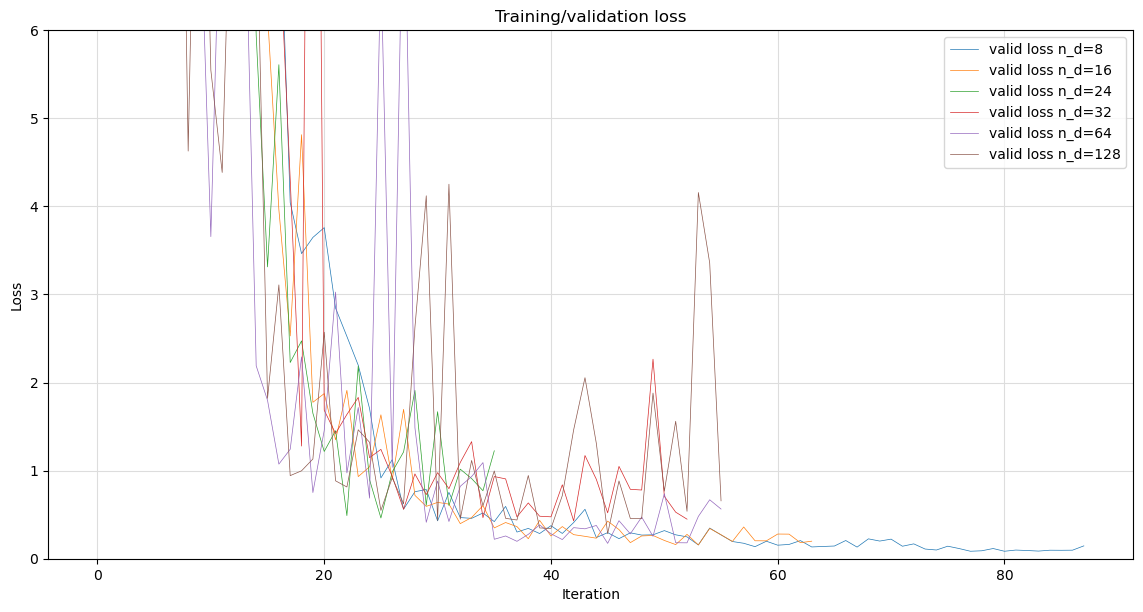

In [93]:
plot_all_losses(valid_losses)

In [94]:
for val in valid_losses['n_d']:
    print(f"{val}\t{min(valid_losses['n_d'][val])}")

8	0.0848061814904213
16	0.15631073713302612
24	0.46249014139175415
32	0.42920345067977905
64	0.1741751730442047
128	0.28429943323135376


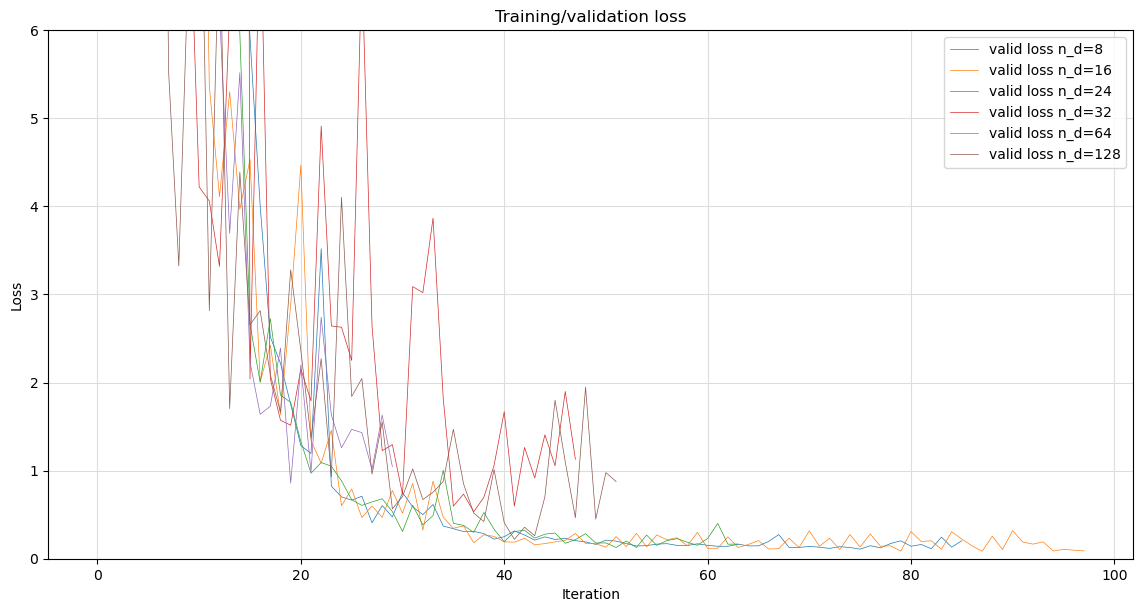

In [97]:
plot_all_losses(valid_losses)

In [98]:
for val in valid_losses['n_d']:
    print(f"{val}\t{min(valid_losses['n_d'][val])}")

8	0.10873789340257645
16	0.08409054577350616
24	0.12704181671142578
32	0.5336658358573914
64	0.8588109016418457
128	0.21979282796382904


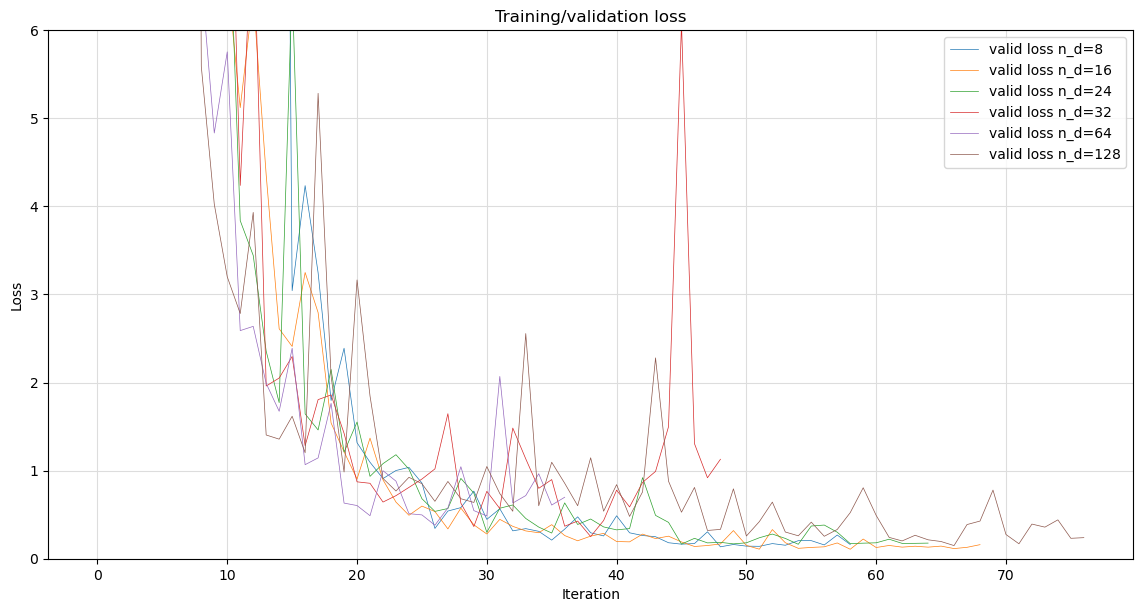

In [101]:
# n_a 128
plot_all_losses(valid_losses)

In [102]:
for val in valid_losses['n_d']:
    print(f"{val}\t{min(valid_losses['n_d'][val])}")

8	0.1351233273744583
16	0.10753074288368225
24	0.1638888418674469
32	0.25185853242874146
64	0.3806673586368561
128	0.1491183340549469


## fit

In [28]:
from torch.nn.functional import mse_loss

In [115]:
tnr = TabNetRegressor(n_d=16, n_a=64,
                      gamma = 1.2,
                      cat_idxs=cat_idxs, cat_dims=cat_dims, cat_emb_dim=cat_emb_dim,
                      lambda_sparse=1e-3,
                      optimizer_params=dict(lr=2e-2),
                      n_steps=5,
                      momentum=0.8)

Device used : cpu


In [ ]:
tnr.fit(X_train=x_train, y_train=y_train,
        X_valid=x_valid, y_valid=y_valid,
        loss_fn=mse_loss,
        weights=0,
        max_epochs=max_epochs, patience=10,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0, drop_last=False)

In [ ]:
preds = np.exp(tnr.predict(x_valid))

In [ ]:
plot_losses(tnr)

In [ ]:
tnr.save_model(PATH)

In [ ]:
plot_losses(tnr)

In [ ]:
preds = np.exp(tnr.predict(x_test))

In [ ]:
preds

In [ ]:
preds_exp = np.exp(preds)

In [ ]:
preds_exp

In [ ]:
preds = preds_exp

In [ ]:
tnr = TabNetRegressor(n_d=16, n_a=16, gamma = 1.2, cat_idxs=cat_idxs, cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, lambda_sparse=1e-3, optimizer_params=dict(lr=2e-2), n_steps=5, momentum=0.8)

In [ ]:
tnr.fit(X_train=x_train, y_train=y_train, X_valid=x_valid, y_valid=y_valid, weights=0, max_epochs=max_epochs, patience=1000, batch_size=1024, virtual_batch_size=128, num_workers=0, drop_last=False)

# Export

In [ ]:
out = 'submission.csv'
with open(PATH/out, 'w') as f:
    f.write('Id,SalePrice\n')
    for e, p in enumerate(preds, start=1461):
        f.write(f'{e},{p.item()}\n')